# Segmentation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.exposure import histogram

Text(0.5, 1.0, 'histogram of gray Values')

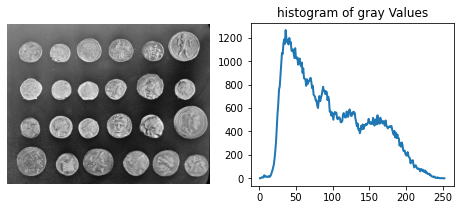

In [3]:
coins = data.coins()
hist, hist_centers = histogram(coins)

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].imshow(coins, cmap='gray')
axes[0].axis('off')
axes[1].plot(hist_centers, hist, lw=2)
axes[1].set_title('histogram of gray Values')

## Thresholding

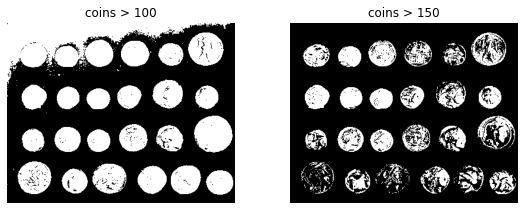

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(8,3), sharey=True)
axes[0].imshow(coins > 100, cmap='gray')
axes[0].set_title('coins > 100')

axes[1].imshow(coins > 150, cmap='gray')
axes[1].set_title('coins > 150')

for a in axes:
    a.axis('off')
    
plt.tight_layout()

### Otsu Threshold

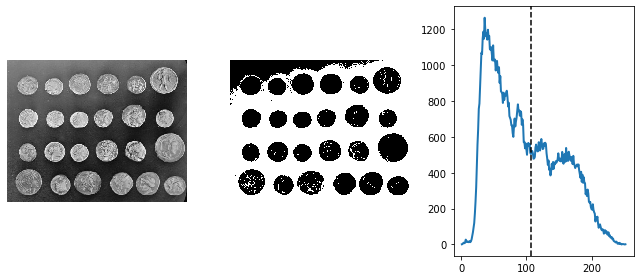

In [8]:
from skimage import filters
from skimage import exposure

val = filters.threshold_otsu(coins)

hist, bins_center = exposure.histogram(coins)

plt.figure(figsize=(9, 4))
plt.subplot(131)
plt.imshow(coins, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.subplot(132)
plt.imshow(coins < val, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.subplot(133)
plt.plot(bins_center, hist, lw=2)
plt.axvline(val, color='k', ls="--")

plt.tight_layout()
plt.show()

## Edge Segmentation

### Canny Edge

(-0.5, 383.5, 302.5, -0.5)

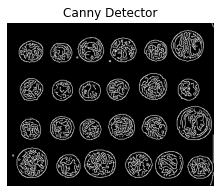

In [10]:
from skimage.feature import canny

edges = canny(coins/255.)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(edges, cmap='gray')
ax.set_title('Canny Detector')
ax.axis('off')

### Filling Holes

(-0.5, 383.5, 302.5, -0.5)

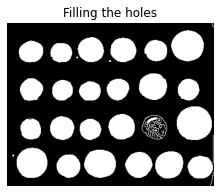

In [11]:
from scipy import ndimage as ndi

fill_coins = ndi.binary_fill_holes(edges)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(fill_coins, cmap='gray')
ax.set_title('Filling the holes')
ax.axis('off')

### Remove small objects

(-0.5, 383.5, 302.5, -0.5)

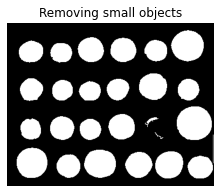

In [13]:
from skimage import morphology

coins_cleaned = morphology.remove_small_objects(fill_coins, 21)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(coins_cleaned, cmap='gray')
ax.set_title('Removing small objects')
ax.axis('off')

## Region Based Segmentation

### Elevation map(sobel)

(-0.5, 383.5, 302.5, -0.5)

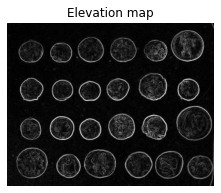

In [14]:
from skimage.filters import sobel 

elevation_map = sobel(coins)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(coins_cleaned, cmap='gray')
ax.set_title('Removing small objects')
ax.axis('off')

### Markers

(-0.5, 383.5, 302.5, -0.5)

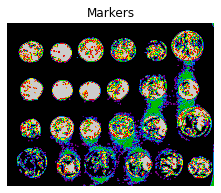

In [16]:
markers = np.zeros_like(coins)
markers[coins < 30] = 1
markers[coins > 150] = 2

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(markers, cmap=plt.cm.nipy_spectral)
ax.set_title('Markers')
ax.axis('off')

### Watershed transform

C:\Users\User\anaconda3\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


(-0.5, 383.5, 302.5, -0.5)

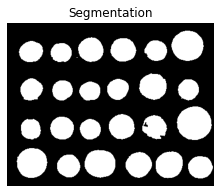

In [31]:
segmentation = morphology.watershed(elevation_map, markers)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(segmentation, cmap='gray')
ax.set_title('Segmentation')
ax.axis('off')

<ipython-input-32-49cb9730f4a4>:5: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  image_label_overlay = label2rgb(labeled_coins, image=coins)


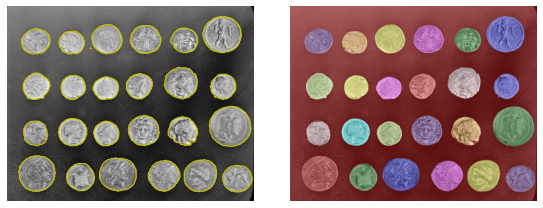

In [32]:
from skimage.color import label2rgb

segmentation = ndi.binary_fill_holes(segmentation - 1)
labeled_coins, _ = ndi.label(segmentation)
image_label_overlay = label2rgb(labeled_coins, image=coins)

fig, ax = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
ax[0].imshow(coins, cmap='gray')
ax[0].contour(segmentation, [0.5], linewidths=1.2, colors='y')
ax[1].imshow(image_label_overlay)

for a in ax:
    a.axis('off')
    
plt.tight_layout()

plt.show()

### OpenCV segmentation

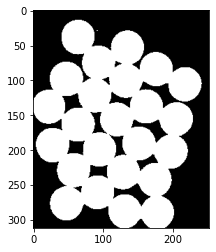

In [37]:
import cv2

img = cv2.imread('Coins.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

plt.imshow(thresh, cmap='gray')

In [40]:
# noise removal
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)

# Sure Background Area
sure_bg = cv2.dilate(opening, kernel, iterations = 3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)

# finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

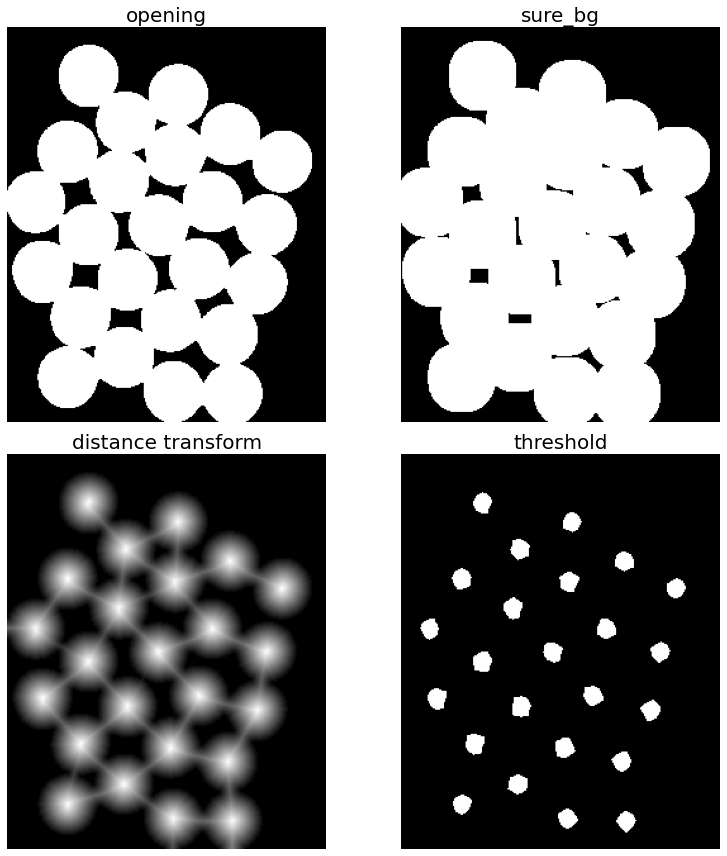

In [41]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12),
                        sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(opening, cmap='gray')
ax[0].axis('off')
ax[0].set_title('opening', fontsize=20)

ax[1].imshow(sure_bg, cmap='gray')
ax[1].axis('off')
ax[1].set_title('sure_bg', fontsize=20)

ax[2].imshow(dist_transform, cmap='gray')
ax[2].axis('off')
ax[2].set_title('distance transform', fontsize=20)

ax[3].imshow(sure_fg, cmap='gray')
ax[3].axis('off')
ax[3].set_title('threshold', fontsize=20)

fig.tight_layout()
plt.show()

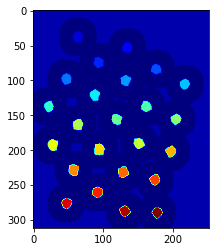

In [42]:
# marker labeling
ret, markers = cv2.connectedComponents(sure_fg)

# add one to all label so that background is not 0, but 1
markers = markers+1

# mark unknown reg of 0
markers[unknown==255] = 0

plt.imshow(markers, cmap=plt.cm.jet)

Text(0.5, 1.0, 'markers')

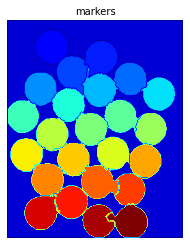

In [43]:
# apply watershed method
markers = cv2.watershed(img, markers)
img[markers == -1] = [255, 0, 0]
plt.imshow(markers, cmap='jet')
plt.axis('off')
plt.title('markers', fontsize=10)